# Stochastic Gradient Descent with Warm Restarts

- https://arxiv.org/pdf/1608.03983

In [18]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class SGDWarmUpRestarts(_LRScheduler):
    """
        optimizer (Optimizer): Wrapped optimizer.
        T0 (int): First cycle step size.
        Tmult(float): Cycle steps magnification. Default: -1.
        max_lr(float): First cycle's max learning rate. Default: 0.1.
        min_lr(float): Min learning rate. Default: 0.001.
        last_epoch (int): The index of last epoch. Default: -1.
    """
    def __init__(self, optimizer, T0, Tmult = 1.0, max_lr = 0.1, min_lr = 0.001, last_epoch = -1):
        # T0는 최초 주기, Tmult는 다음 주기가 몇 배 늘어나는지
        # max_lr는 LR이 얼마까지 높아지는지
        self.first_cycle_steps = T0
        self.Tmult = Tmult
        self.max_lr = max_lr                            # max learning rate in the current cycle
        self.min_lr = min_lr                            # min learning rate
        
        self.cur_cycle_steps = T0                       # first cycle step size
        self.cycle = 0                                  # cycle count
        self.step_in_cycle = last_epoch                 # step size of the current cycle

        super(SGDWarmUpRestarts, self).__init__(optimizer, last_epoch)
        
        # set learning rate min_lr
        self.init_lr()
    
    def init_lr(self):
        self.base_lrs = []
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = self.min_lr
            self.base_lrs.append(self.min_lr)
        # parameter에 저장된 LR을 처음 LR로 저장
    
    def get_lr(self):
        if self.step_in_cycle == -1:                    # 첫 시작일 때
            return self.base_lrs                        # 그냥 base LR을 반영
        return [base_lr + (self.max_lr - base_lr) * (1 + math.cos(math.pi * (self.step_in_cycle) / (self.cur_cycle_steps))) / 2
                for base_lr in self.base_lrs]
        #cosine annealing을 적용

    def step(self):
        epoch = self.last_epoch + 1
        self.step_in_cycle = self.step_in_cycle + 1
        if self.step_in_cycle >= self.cur_cycle_steps:
            self.cycle += 1
            self.step_in_cycle = self.step_in_cycle - self.cur_cycle_steps
            self.cur_cycle_steps = int(self.cur_cycle_steps * self.Tmult)            
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

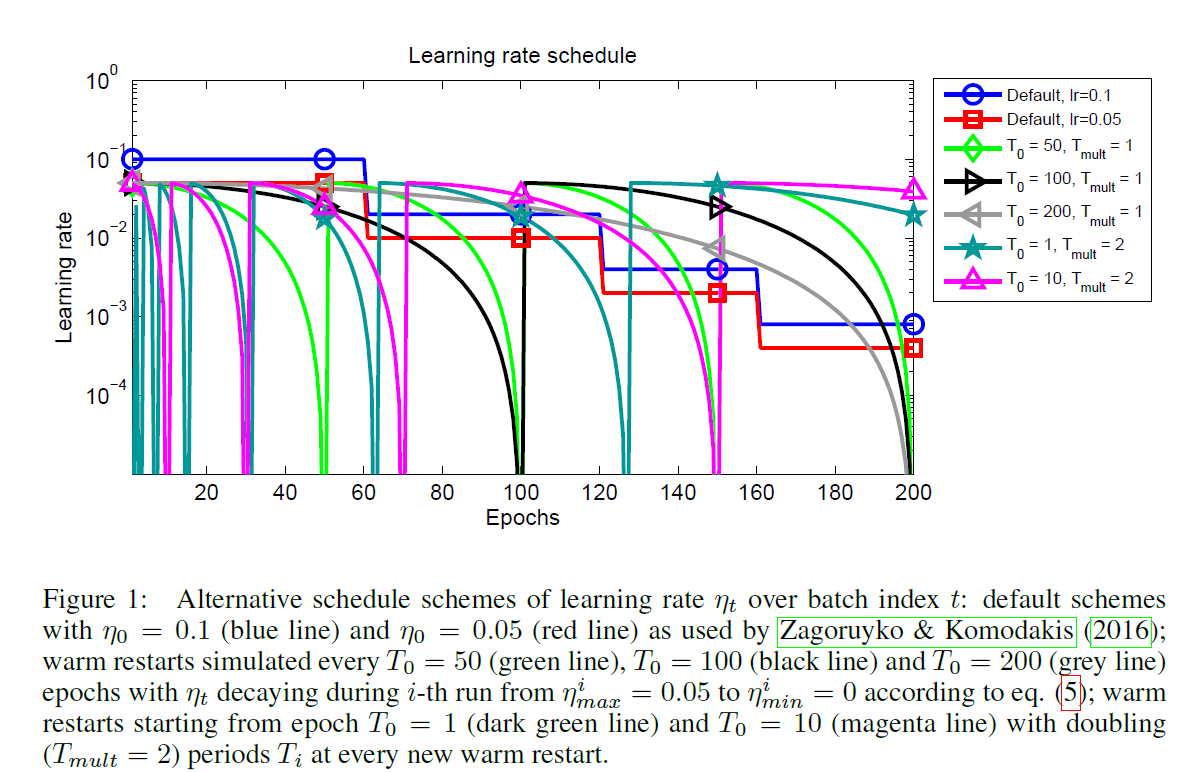

- Initial setting

In [20]:
import torch
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 200
model = torch.nn.Linear(2, 1)

In [21]:
def make_lr_chart(optimizer, T0, Tmult, num_epochs, X, color, marker):
    lr_scheduler = SGDWarmUpRestarts(optimizer, T0 = T0, Tmult = Tmult, max_lr = 0.05, min_lr = 0, last_epoch = -1)
    lr = []
    for i in range(num_epochs):
        lr_scheduler.step()
        lr.append(optimizer.param_groups[0]["lr"])
    plt.plot(X, lr, label = f'T0={T0}, Tmult={Tmult}', color=color, marker=marker, markevery=50, markersize=12)

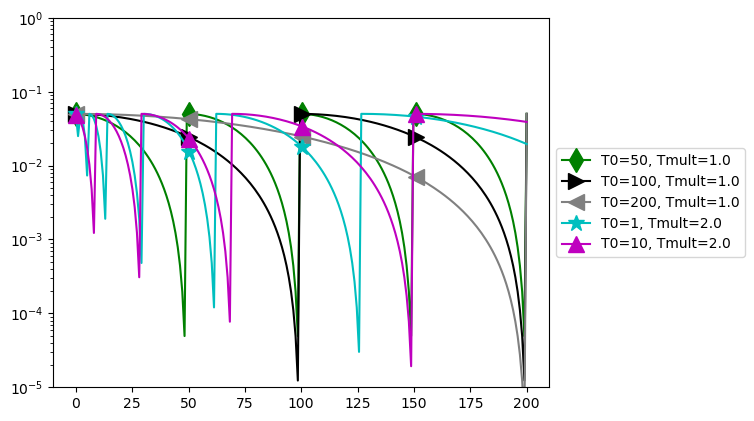

In [25]:
X = np.linspace(0, 200, 200)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)

make_lr_chart(optimizer, 50, 1.0, num_epochs, X, 'g', "d")
make_lr_chart(optimizer, 100, 1.0, num_epochs, X, 'k', ">")
make_lr_chart(optimizer, 200, 1.0, num_epochs, X, '#808080', "<")
make_lr_chart(optimizer, 1, 2.0, num_epochs, X, 'c', "*")
make_lr_chart(optimizer, 10, 2.0, num_epochs, X, 'm', "^")

plt.yscale('log', base=10)
plt.ylim([1e-5 , 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()